In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import matplotlib.dates as mdates
import datetime as dt 

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

import yfinance as yf
from pandas_datareader import data

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

2022-11-02 16:49:08.324010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tm = yf.download('TM', start='2017-10-28', end='2022-10-28')
tm


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,124.250000,124.440002,124.070000,124.389999,124.389999,113500
2017-10-31,123.980003,124.139999,123.669998,124.000000,124.000000,110400
2017-11-01,124.290001,124.919998,124.180000,124.430000,124.430000,194200
2017-11-02,125.050003,125.489998,124.940002,125.309998,125.309998,153100
2017-11-03,125.510002,125.629997,125.019997,125.620003,125.620003,115300
...,...,...,...,...,...,...
2022-10-21,131.690002,133.919998,131.339996,133.759995,133.759995,313600
2022-10-24,133.630005,135.100006,133.139999,134.740005,134.740005,188300
2022-10-25,135.880005,137.910004,135.779999,137.070007,137.070007,193100


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

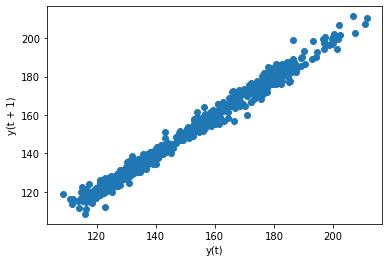

In [3]:
lag_plot(tm.Close)

mean : 142.93701903278006


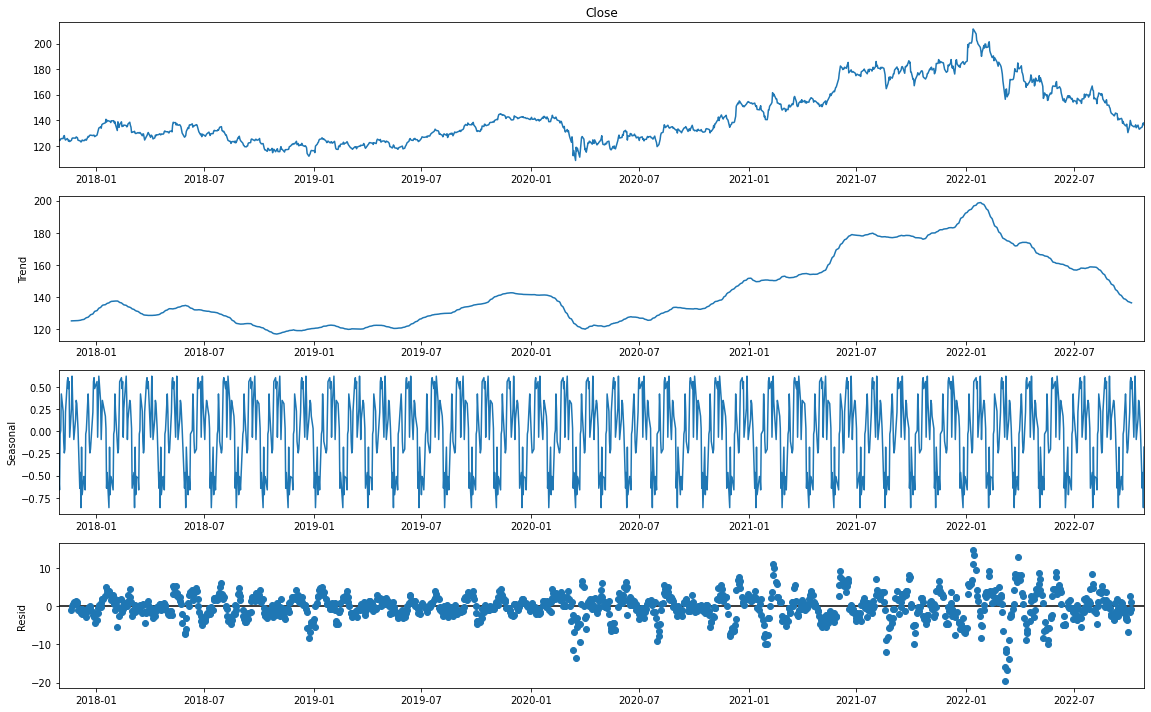

In [4]:
import statsmodels.api as sm
print('mean :' , tm.Close.mean())
res = sm.tsa.seasonal_decompose(tm.Close, period=30)
resplot = res.plot()
resplot.set_size_inches((16,10))
resplot.tight_layout()



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

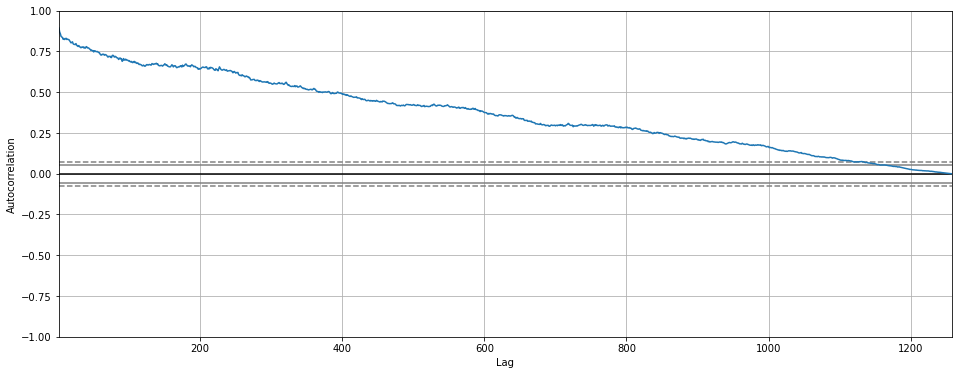

In [5]:
plt.figure(figsize=(16,6))
autocorrelation_plot(tm)

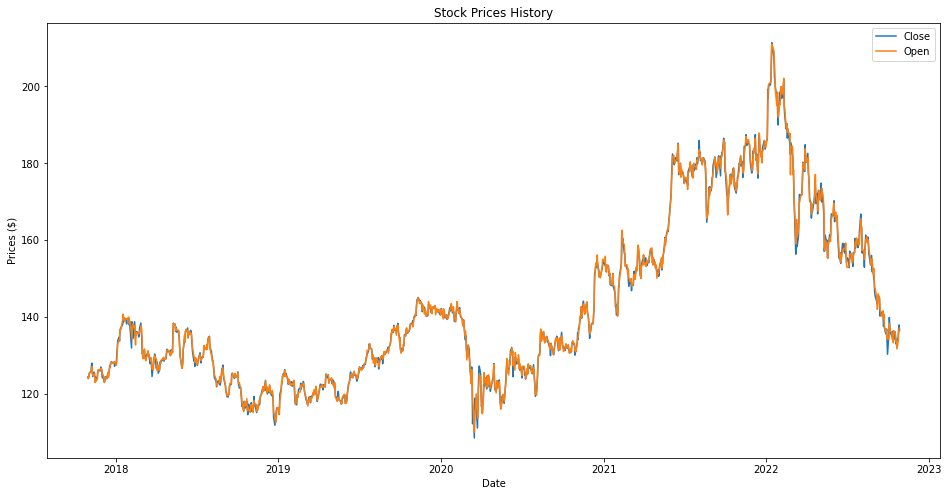

In [6]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(tm['Close'], label='Close')
plt.plot(tm['Open'], label='Open')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

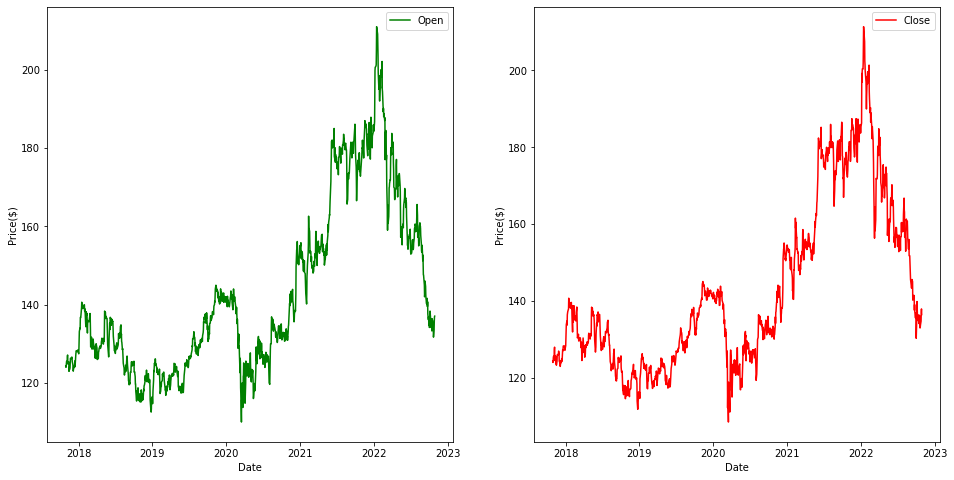

In [7]:
fg, ax =plt.subplots(1,2,figsize=(16,8))
ax[0].plot(tm['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=10)
ax[0].set_ylabel('Price($)',size=10)
ax[0].legend()
ax[1].plot(tm['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=10)
ax[1].set_ylabel('Price($)',size=10)
ax[1].legend()
plt.show()

In [8]:
close_prices = tm['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-30: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
%%time
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) # return=True so the output of the layer will be another sequence of the same length
model.add(layers.LSTM(100, return_sequences=False)) # reture=false to only return the last output in the output sequence
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()



2022-11-02 16:49:49.386828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1.04 s, sys: 93.1 ms, total: 1.13 s
Wall time: 2.68 s


In [10]:
%%time
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 30, epochs=20)

Epoch 1/20
33/33 [==============================] - 14s 60ms/step - loss: 0.0091
Epoch 2/20
33/33 [==============================] - 2s 62ms/step - loss: 0.0017
Epoch 3/20
33/33 [==============================] - 2s 52ms/step - loss: 0.0014
Epoch 4/20
33/33 [==============================] - 2s 54ms/step - loss: 0.0012
Epoch 5/20
33/33 [==============================] - 2s 53ms/step - loss: 0.0011
Epoch 6/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0011
Epoch 7/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0010
Epoch 8/20
33/33 [==============================] - 1s 38ms/step - loss: 0.0010
Epoch 9/20
33/33 [==============================] - 1s 39ms/step - loss: 9.2156e-04
Epoch 10/20
33/33 [==============================] - 1s 35ms/step - loss: 8.7892e-04
Epoch 11/20
33/33 [==============================] - 1s 35ms/step - loss: 7.9759e-04
Epoch 12/20
33/33 [==============================] - 1s 30ms/step - loss: 7.3597e-04
Epoch 13/20
33/33 [=

In [11]:
%%time
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 1s 10ms/step
CPU times: user 904 ms, sys: 77.3 ms, total: 982 ms
Wall time: 828 ms


1.7656329637504669

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


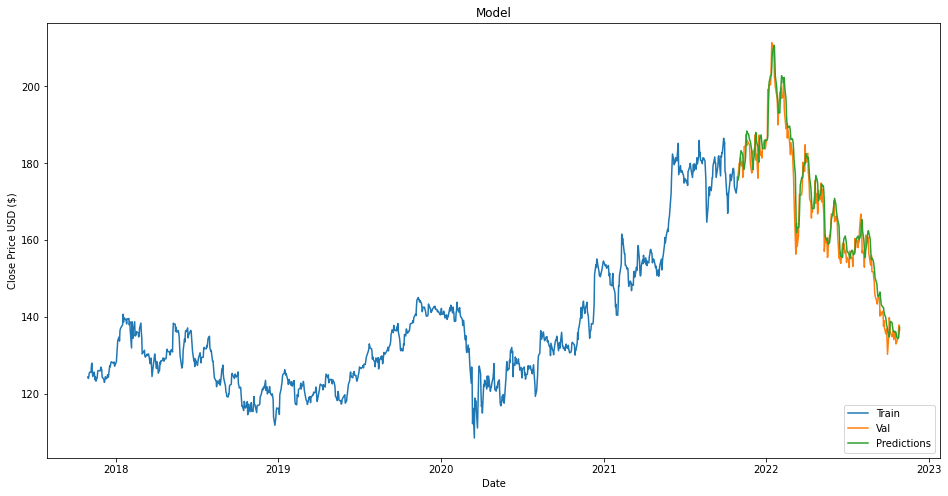

CPU times: user 472 ms, sys: 280 ms, total: 752 ms
Wall time: 760 ms


In [12]:
%%time
data = tm.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

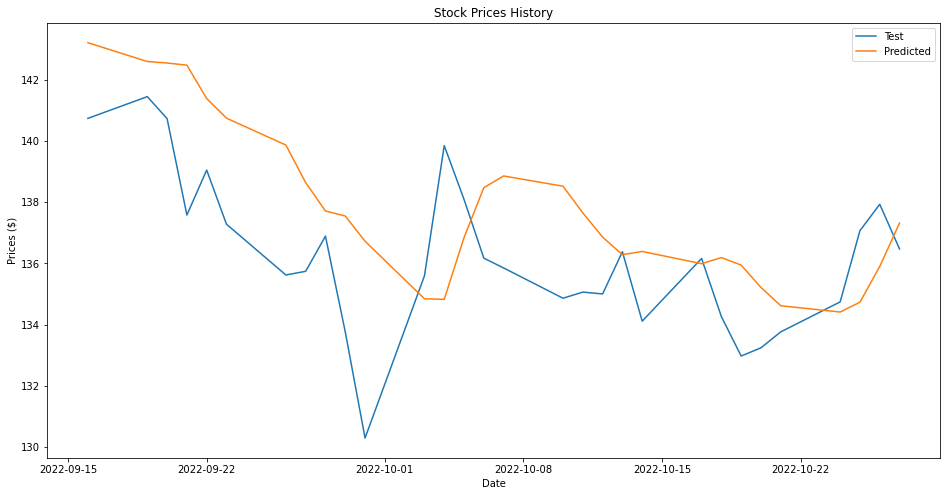

In [13]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(validation['Close'].iloc[-30:], label='Test')
plt.plot(validation['Predictions'].iloc[-30:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

# graphing just last 60 days of test vs predictions 

In [14]:
from pandas import Timestamp
start = Timestamp('2022-10-28')
end = Timestamp('2022-10-28')

all_dates = pd.date_range(start=start, end=end, freq='D')

# You can fill the "Value" column with any value you want. Here I filled with 0.
future = pd.DataFrame({'Date':all_dates , 'Value':[0]*len(all_dates)})
# future

future.index = pd.DatetimeIndex(future.Date, freq=None)
# future

future = future.drop(['Date'], axis=1)
future

,Value
Date,
2022-10-28,0


In [15]:
futurepredictions = model.predict(future)
futurepredictions = scaler.inverse_transform(futurepredictions)

1/1 [==============================] - 1s 593ms/step


In [16]:
futurepredictions[0]

array([112.09506], dtype=float32)

In [17]:
# prediction a bit off but is the nature

In [18]:
tm

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,124.250000,124.440002,124.070000,124.389999,124.389999,113500
2017-10-31,123.980003,124.139999,123.669998,124.000000,124.000000,110400
2017-11-01,124.290001,124.919998,124.180000,124.430000,124.430000,194200
2017-11-02,125.050003,125.489998,124.940002,125.309998,125.309998,153100
2017-11-03,125.510002,125.629997,125.019997,125.620003,125.620003,115300
...,...,...,...,...,...,...
2022-10-21,131.690002,133.919998,131.339996,133.759995,133.759995,313600
2022-10-24,133.630005,135.100006,133.139999,134.740005,134.740005,188300
2022-10-25,135.880005,137.910004,135.779999,137.070007,137.070007,193100


In [19]:
testtm = tm.iloc[-251:]

In [20]:
testtm['predict'] = predictions

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_85481/3151535061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testtm['predict'] = predictions


In [21]:
testtm = testtm[['Close', 'predict']]
testtm

,Close,predict
Date,,
2021-10-29,176.570007,175.578400
2021-11-01,179.979996,177.191132
2021-11-02,179.610001,179.627579
2021-11-03,181.070007,181.252090
2021-11-04,181.479996,182.543427
...,...,...
2022-10-21,133.759995,134.614059
2022-10-24,134.740005,134.409088
2022-10-25,137.070007,134.729828


In [22]:
testtm['diff'] = testtm['predict'] - testtm['Close']
testtm

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_85481/585986911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testtm['diff'] = testtm['predict'] - testtm['Close']


,Close,predict,diff
Date,,,
2021-10-29,176.570007,175.578400,-0.991608
2021-11-01,179.979996,177.191132,-2.788864
2021-11-02,179.610001,179.627579,0.017578
2021-11-03,181.070007,181.252090,0.182083
2021-11-04,181.479996,182.543427,1.063431
...,...,...,...
2022-10-21,133.759995,134.614059,0.854065
2022-10-24,134.740005,134.409088,-0.330917
2022-10-25,137.070007,134.729828,-2.340179


In [23]:
testtm.to_csv('tm.csv', index=False)

In [27]:
# nflx.to_csv('nflxrealclose.csv', index=False)
tm.to_csv('tmrealclose.csv', index = True)

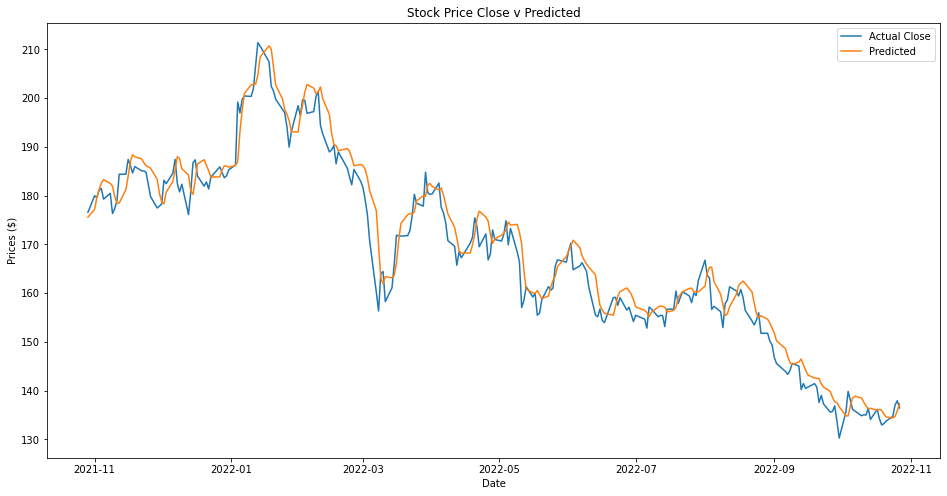

In [25]:
plt.figure(figsize=(16, 8))
plt.title('Stock Price Close v Predicted')
plt.plot(testtm['Close'], label='Actual Close')
plt.plot(testtm['predict'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()